# Project Goal
## Bussiness Object
* Build Predictive maintenance models to predict the probability of device failure based on a year’s worth of data, Which can help determine wheather or not a maintenance should be performed to the in-service equipment.
## Technical Object
* The target model should minimize false positives(specificity) and false negatives(sensitivity) as much as possible.
* Find out how to deal with imbalanced dataset.

In [ ]:
pd.DataFrame()

# Data exploration

## Import moduels

In [103]:
#import moduels
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#xgb=XGBClassifier()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from xgboost import XGBClassifier
import pandas_profiling

import pandas as pd
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
#import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

## Load data as dataframe and data overview

In [2]:
df = pd.read_csv('failures_prediction.csv')

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,124494
Total Missing (%),0.0%
Total size in memory,11.4 MiB
Average record size in memory,96.0 B
Numeric,8
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [5]:
#no missing values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [6]:
#imbalanced classification problem
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [7]:
#no duplicated observations
df.duplicated().sum()

#output number of unique values for each column,
#7 attributes have very high percentage of zero values. 
#These could be error codes or some other indicator, I will change their data types later.
#cols = df.columns
#for col in cols:
#    print(col)
#    print(df[col].nunique())
#
#df.columns

0

In [8]:
df.nunique()

date             304
device          1168
failure            2
attribute1    123878
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

## Summary
* This dataset is clean, no missing values. All attributes are integer data type.
* It is imbalanced data set, as the failuer class is about 0.1% of unfailure class.Here oversampling approach is used to deal with imbalanced dataset.
* Some attributes have limited number of distictive values, very sparse, indicating that they are likely to be categorical variable, such as attibute 3, 5,7,9.
* Attribute7 and 8 seems like exactly same to each other, we can drop one of them.
* Attribute 2,3,4,7,9 are highly skewed.
* Attributes differ in their magnitudes. Scaling or centering is requried.

# Data Engineering

## 'Date' exploration

### Create features bsed on date

In [9]:
# create three more features based on date.
df.date = pd.to_datetime(df.date)

df['activedays']=df.date-df.date[0]

df['month']=df['date'].dt.month
df['week_day']=df.date.dt.weekday
df['week_day'].replace(0,7,inplace=True)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,week_day
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,0 days,1,3
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,0 days,1,3
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,0 days,1,3
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,0 days,1,3
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,0 days,1,3


In [10]:
#season = []
#for dt in df.date:
#    if dt < datetime(2015,3,1):
#        season.append('winter')
#    elif dt < datetime(2015,6,1):
#        season.append('spring')
#    elif dt<datetime(2015,9,1):
#        season.append('summer')
#    else:
#        season.append('fall')
#        
#df['season']=season
#df.head()

In [11]:
df.groupby('month').agg({'device':lambda x: x.nunique()})

,device
month,
1,1164
2,726
3,685
4,491
5,424
6,352
7,346
8,334
9,184


### Data visualization in Date

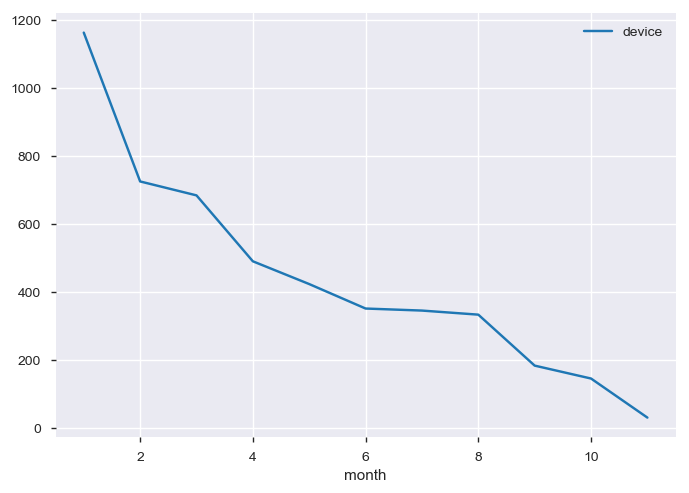

In [12]:
df.groupby('month').agg({'device':lambda x: x.nunique()}).plot()

This figure shows that as time move on, the number of devices are getting less and less.

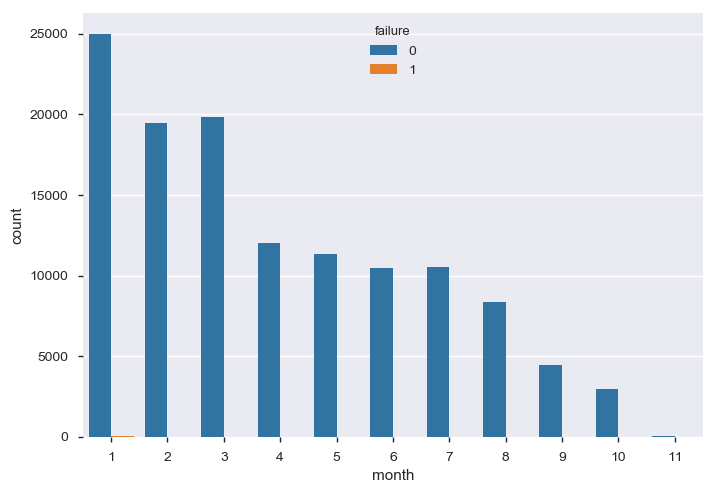

In [13]:
ax = sns.countplot(x="month", hue="failure", data=df)

This figure shows most of the devices failed in the first month.

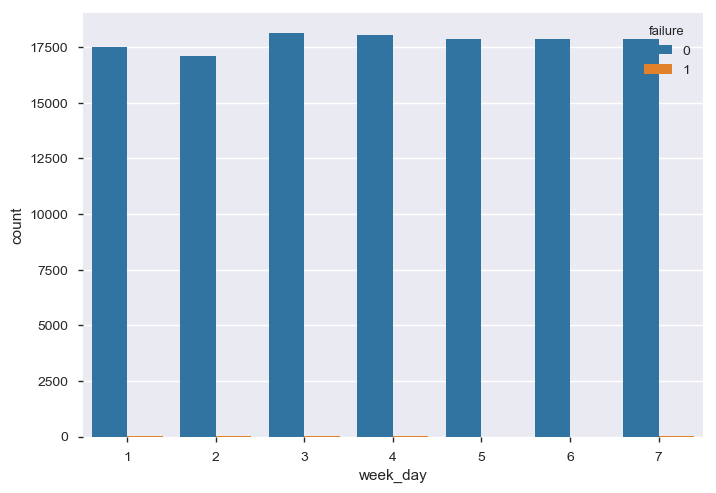

In [14]:
ax = sns.countplot(x='week_day',hue='failure',data=df)

This figure shows that there is no device fails on Friday and Saturday. Maybe they don't work on the two days.

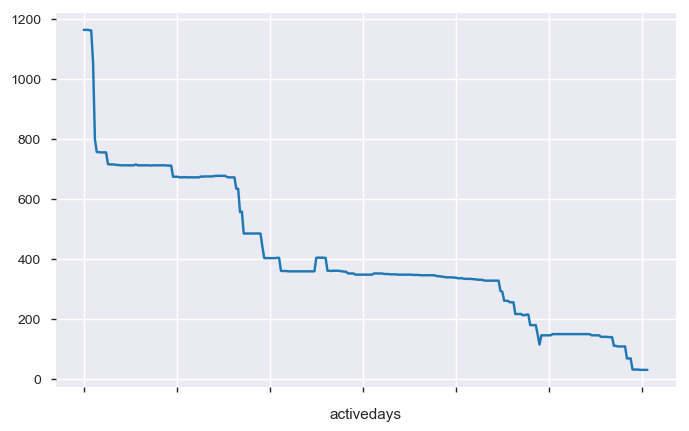

In [15]:
df.groupby('activedays')['device'].count().plot()

 One can see that the number of devices decreases as time goes by. And there is a big jump in the middle of activedays. Those may be some devices got put back in after they failed and fixed well. We will investigate the detail later.

In [16]:
#df.info()
#
#q=df.groupby('device')['failure'].mean()
#
#q=q.to_dict()
#q
#
#df['failure_rate']=df['device'].map(q)
#
#df.head()

In [17]:
max(df.date), min(df.date)

(Timestamp('2015-11-02 00:00:00'), Timestamp('2015-01-01 00:00:00'))

All of these data are collected between 11/02/2015 and 01/01/2015

### Devices come back to use

In [18]:
df_date = df.groupby('device').agg({'date':max})

df_date.date.to_dict()

df_failure = df.loc[df.failure==1,['device','date']]


df_good = df.loc[df.failure==0,['device','date']]

df_date.shape,df_failure.shape

df['max_date']=df.device.map(df_date.date.to_dict())

df.head()

#dfa = df[~df.device.isin(df_failure.device)]

dff=df[(df.failure==1)&(df.date!=df.max_date)]
dff

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,week_day,max_date
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,124 days,5,1,2015-05-06
79590,2015-05-09,W1F0KCP2,1,176861128,10392,0,121,6,310699,0,0,0,128 days,5,5,2015-05-11
79601,2015-05-09,W1F0M35B,1,141805096,0,0,1,7,267203,0,0,0,128 days,5,5,2015-05-11
101999,2015-07-12,S1F0GPFZ,1,236544080,0,0,0,9,264594,0,0,0,192 days,7,6,2015-07-24
104223,2015-07-18,W1F11ZG9,1,32671632,368,9,486,3,344433,0,0,1,198 days,7,5,2015-08-17


Max date means the last day the device got checked. If the max day is ahead of failure date, it means this device returned to use after failed because got fixed.

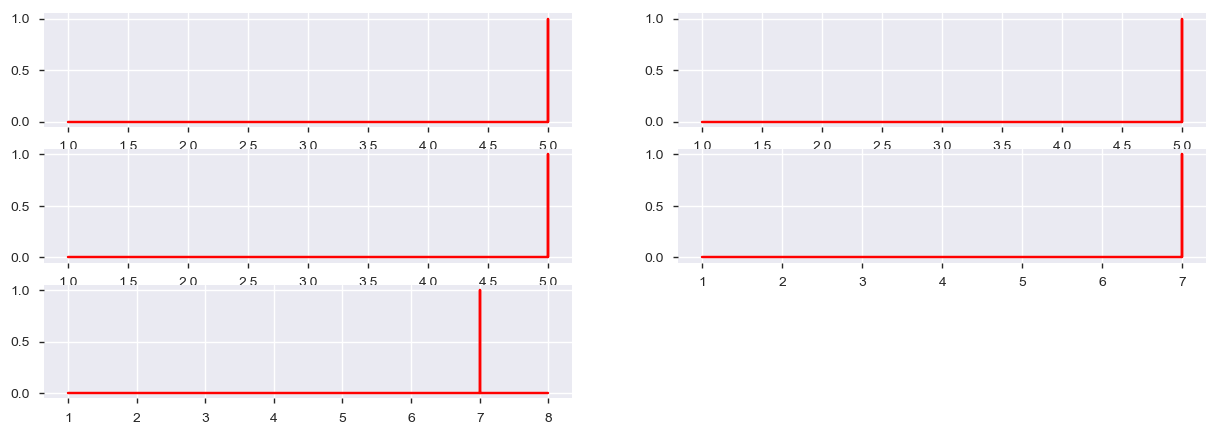

In [19]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(3, 2, 1) 
plt.plot(df.loc[df['device']=='S1F136J0',['failure','month']]['month'],df.loc[df['device']=='S1F136J0',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 2) 
plt.plot(df.loc[df['device']=='W1F0KCP2',['failure','month']]['month'],df.loc[df['device']=='W1F0KCP2',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 3)
plt.plot(df.loc[df['device']=='W1F0M35B',['failure','month']]['month'],df.loc[df['device']=='W1F0M35B',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 4)
plt.plot(df.loc[df['device']=='S1F0GPFZ',['failure','month']]['month'],df.loc[df['device']=='S1F0GPFZ',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 5)
plt.plot(df.loc[df['device']=='W1F11ZG9',['failure','month']]['month'],df.loc[df['device']=='W1F11ZG9',\
         ['failure','month']]['failure'],\
         color = 'red')

plt.show()

In [20]:
df[df.device == 'S1F136J0']

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,week_day,max_date
500,2015-01-01,S1F136J0,0,229928576,0,0,25,16,312312,0,0,0,0 days,1,3,2015-05-06
1663,2015-01-02,S1F136J0,0,6051808,0,0,25,16,313710,0,0,0,1 days,1,4,2015-05-06
2826,2015-01-03,S1F136J0,0,29281832,0,0,25,16,315035,0,0,0,2 days,1,5,2015-05-06
3989,2015-01-04,S1F136J0,0,54942936,0,0,25,16,316364,0,0,0,3 days,1,6,2015-05-06
5150,2015-01-05,S1F136J0,0,73810232,0,0,25,16,317707,0,0,0,4 days,1,7,2015-05-06
6268,2015-01-06,S1F136J0,0,97425048,0,0,25,16,319072,0,0,0,5 days,1,1,2015-05-06
7215,2015-01-07,S1F136J0,0,119717992,0,0,25,16,320410,0,0,0,6 days,1,2,2015-05-06
7980,2015-01-08,S1F136J0,0,149769424,0,0,25,16,321748,0,0,0,7 days,1,3,2015-05-06
8736,2015-01-09,S1F136J0,0,171306504,0,0,25,16,323083,0,0,0,8 days,1,4,2015-05-06
9492,2015-01-10,S1F136J0,0,197821224,0,0,25,16,324430,0,0,0,9 days,1,5,2015-05-06


In [21]:
#for col in ['attribute1', 'attribute2', 'attribute3',
#       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
#       'attribute9']:
#sns.lmplot(x='attribute1',y='failure',data=df,logistic=True,y_jitter=.03)

## Reduce data set with unique device id

In [22]:
df.attribute1.nunique()

123878

In [23]:
# Here I just keep the last record, as it comes with the most usefull infomation.
df1 = df.groupby('device').agg({'date':max})

In [24]:
df1.shape

(1168, 1)

In [25]:
df1=df1.reset_index()

df=df.reset_index(drop=True) 

df2= pd.merge(df1,df,how='left',on=['device','date'])

df2.shape


(1168, 16)

In [26]:
df2.tail()

,device,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,week_day,max_date
1163,Z1F1VMZB,2015-10-19,0,96949360,0,0,0,5,263507,0,0,0,291 days,10,7,2015-10-19
1164,Z1F1VQFY,2015-06-30,1,178051496,0,0,0,7,265316,0,0,0,180 days,6,1,2015-06-30
1165,Z1F26YZB,2015-03-25,0,229065488,0,1,0,1,292052,0,0,0,83 days,3,2,2015-03-25
1166,Z1F282ZV,2015-03-25,0,72717600,0,1,0,1,192919,0,0,0,83 days,3,2,2015-03-25
1167,Z1F2PBHX,2015-04-06,0,130522432,0,0,0,5,164020,0,0,0,95 days,4,7,2015-04-06


### Create  feature called  'failure_before' 

If we just take the last record for the devices, we may lose information from those come back after failed ones

In [27]:
df2['failure_before']=0

In [28]:
df2.loc[df2.device == 'S1F136J0','failure_before'] = 1
df2.loc[df2.device == 'W1F0KCP2','failure_before'] = 1
df2.loc[df2.device == 'W1F0M35B','failure_before'] = 1
df2.loc[df2.device == 'S1F0GPFZ','failure_before'] = 1
df2.loc[df2.device == 'W1F11ZG9','failure_before'] = 1

## Redefine device Id value

In [29]:
df2.device

0       S1F01085
1       S1F013BB
2       S1F0166B
3       S1F01E6Y
4       S1F01JE0
5       S1F01R2B
6       S1F01TD5
7       S1F01XDJ
8       S1F023H2
9       S1F02A0J
10      S1F02DZ2
11      S1F02EVN
12      S1F02L38
13      S1F02MGA
14      S1F02P76
15      S1F02VAX
16      S1F02W1L
17      S1F02WFT
18      S1F02XLX
19      S1F0318A
20      S1F0322R
21      S1F0330P
22      S1F03499
23      S1F035SJ
24      S1F0377V
25      S1F039FE
26      S1F03RV3
27      S1F03YZM
28      S1F044ET
29      S1F049RX
          ...   
1138    Z1F1A0LM
1139    Z1F1A0RP
1140    Z1F1A1HH
1141    Z1F1A7MG
1142    Z1F1A83K
1143    Z1F1AD0M
1144    Z1F1AF54
1145    Z1F1AFF2
1146    Z1F1AFT5
1147    Z1F1AG5N
1148    Z1F1AGLA
1149    Z1F1AGN5
1150    Z1F1AGW1
1151    Z1F1B6H4
1152    Z1F1B6NP
1153    Z1F1B799
1154    Z1F1CZ35
1155    Z1F1FCH5
1156    Z1F1FZ9J
1157    Z1F1HEQR
1158    Z1F1HSWK
1159    Z1F1Q9BD
1160    Z1F1R76A
1161    Z1F1RE71
1162    Z1F1RJFA
1163    Z1F1VMZB
1164    Z1F1VQFY
1165    Z1F26Y

In [30]:
Id = df2.device.values.tolist()

In [31]:
#change device id values to the first four characters
Id1 = [] 
for i in Id:
    i = i[:4]
    Id1.append(i)

df2.device=Id1

df2.device.value_counts()

S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    137
Z1F1     67
Z1F2      3
Name: device, dtype: int64

In [32]:
dev=pd.crosstab(df2['device'],df2['failure']) 

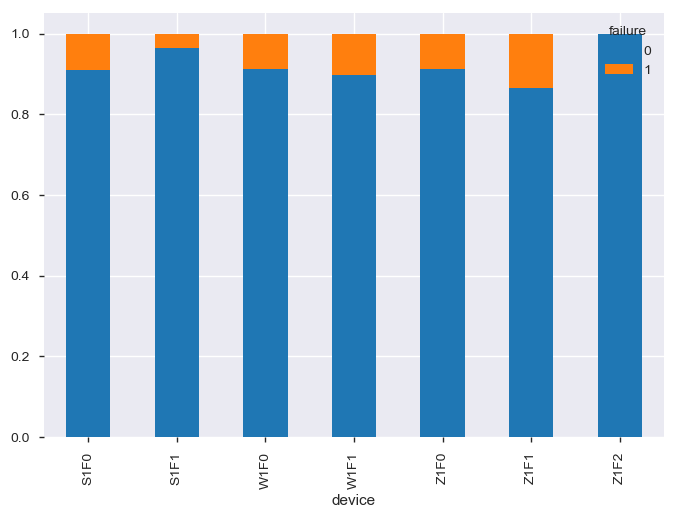

In [33]:
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 

Devices ID begins with ZIF0 fails the most, then W1F1 second

## Data transformation

### Redefing data types

In [34]:

#redefine data type for some of the numerical features
cat_ftrs = ['attribute3','attribute4', 'attribute5', 'attribute7', 'attribute9'] 
for col in cat_ftrs:
    df2[col]=df2[col].astype('object')

In [35]:
# change activedays datatype to numerical
def str_to_num(str):
    return str.split(' ')[0]

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 17 columns):
device            1168 non-null object
date              1168 non-null datetime64[ns]
failure           1168 non-null int64
attribute1        1168 non-null int64
attribute2        1168 non-null int64
attribute3        1168 non-null object
attribute4        1168 non-null object
attribute5        1168 non-null object
attribute6        1168 non-null int64
attribute7        1168 non-null object
attribute8        1168 non-null int64
attribute9        1168 non-null object
activedays        1168 non-null timedelta64[ns]
month             1168 non-null int64
week_day          1168 non-null int64
max_date          1168 non-null datetime64[ns]
failure_before    1168 non-null int64
dtypes: datetime64[ns](2), int64(8), object(6), timedelta64[ns](1)
memory usage: 164.2+ KB


In [36]:
df2.activedays = df2.activedays.astype('str')

df2.activedays=df2.activedays.apply(str_to_num)
df2.activedays = df2.activedays.astype('int')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 17 columns):
device            1168 non-null object
date              1168 non-null datetime64[ns]
failure           1168 non-null int64
attribute1        1168 non-null int64
attribute2        1168 non-null int64
attribute3        1168 non-null object
attribute4        1168 non-null object
attribute5        1168 non-null object
attribute6        1168 non-null int64
attribute7        1168 non-null object
attribute8        1168 non-null int64
attribute9        1168 non-null object
activedays        1168 non-null int64
month             1168 non-null int64
week_day          1168 non-null int64
max_date          1168 non-null datetime64[ns]
failure_before    1168 non-null int64
dtypes: datetime64[ns](2), int64(9), object(6)
memory usage: 164.2+ KB


In [37]:
for col in ['month','week_day']:
    df2[col]=df2[col].astype('object')

### Data standarlization

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Log-Transformed Distribution')

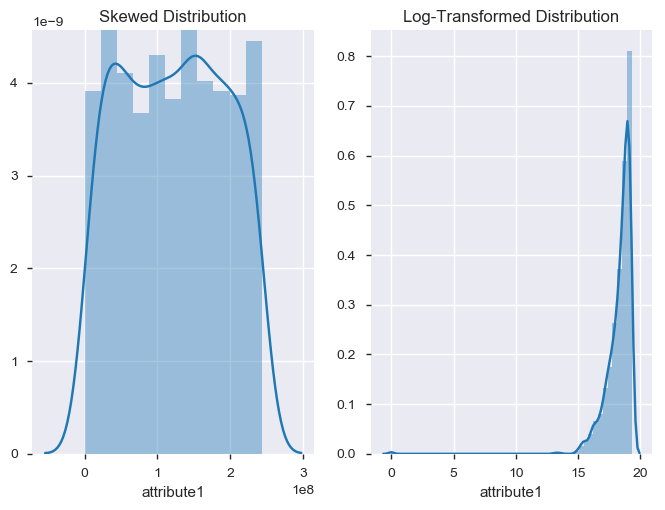

In [38]:
#numerical features normalization
f, axarr = plt.subplots(1,2) 
sns.distplot(df2['attribute1'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['attribute1']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

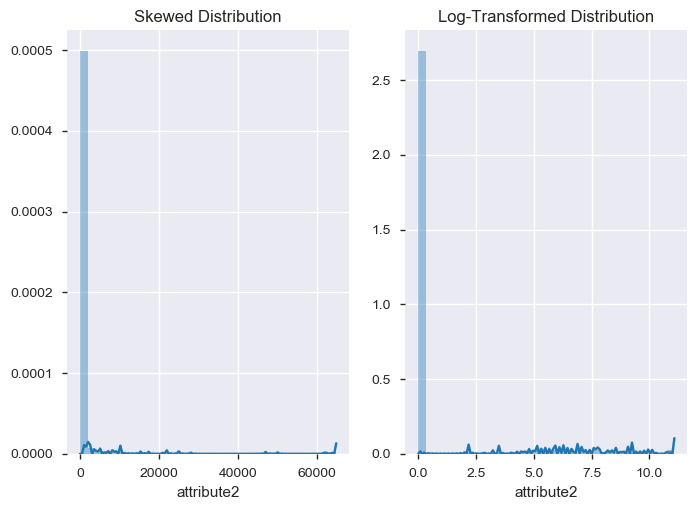

In [39]:
f, axarr = plt.subplots(1,2) 

sns.distplot(df2['attribute2'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['attribute2']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

Text(0.5, 1.0, 'Log-Transformed Distribution')

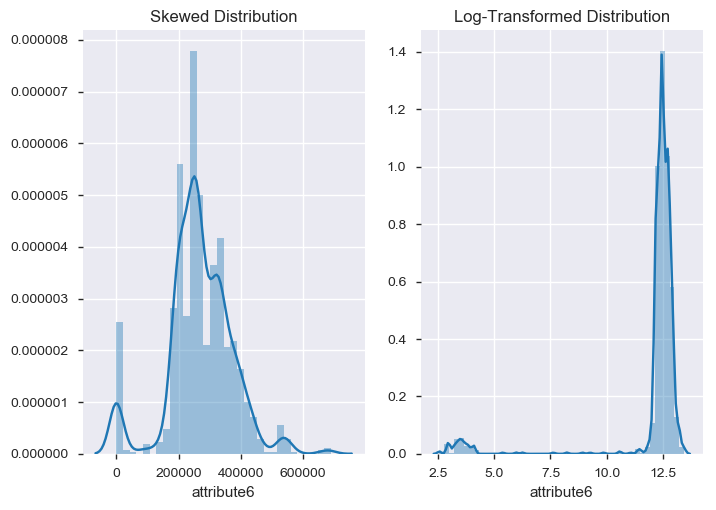

In [40]:
f, axarr = plt.subplots(1,2) 
sns.distplot(df2['attribute6'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['attribute6']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

It seems the data get more skewed after log, so I'd rather not take log on them.

In [41]:
#numerical features standardization
num_ftrs =['attribute1','attribute2','attribute6'] 
df2[num_ftrs]=scaler.fit_transform(df2[num_ftrs])

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 17 columns):
device            1168 non-null object
date              1168 non-null datetime64[ns]
failure           1168 non-null int64
attribute1        1168 non-null float64
attribute2        1168 non-null float64
attribute3        1168 non-null object
attribute4        1168 non-null object
attribute5        1168 non-null object
attribute6        1168 non-null float64
attribute7        1168 non-null object
attribute8        1168 non-null int64
attribute9        1168 non-null object
activedays        1168 non-null int64
month             1168 non-null object
week_day          1168 non-null object
max_date          1168 non-null datetime64[ns]
failure_before    1168 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(4), object(8)
memory usage: 164.2+ KB


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Drop unimportant and redundant features 

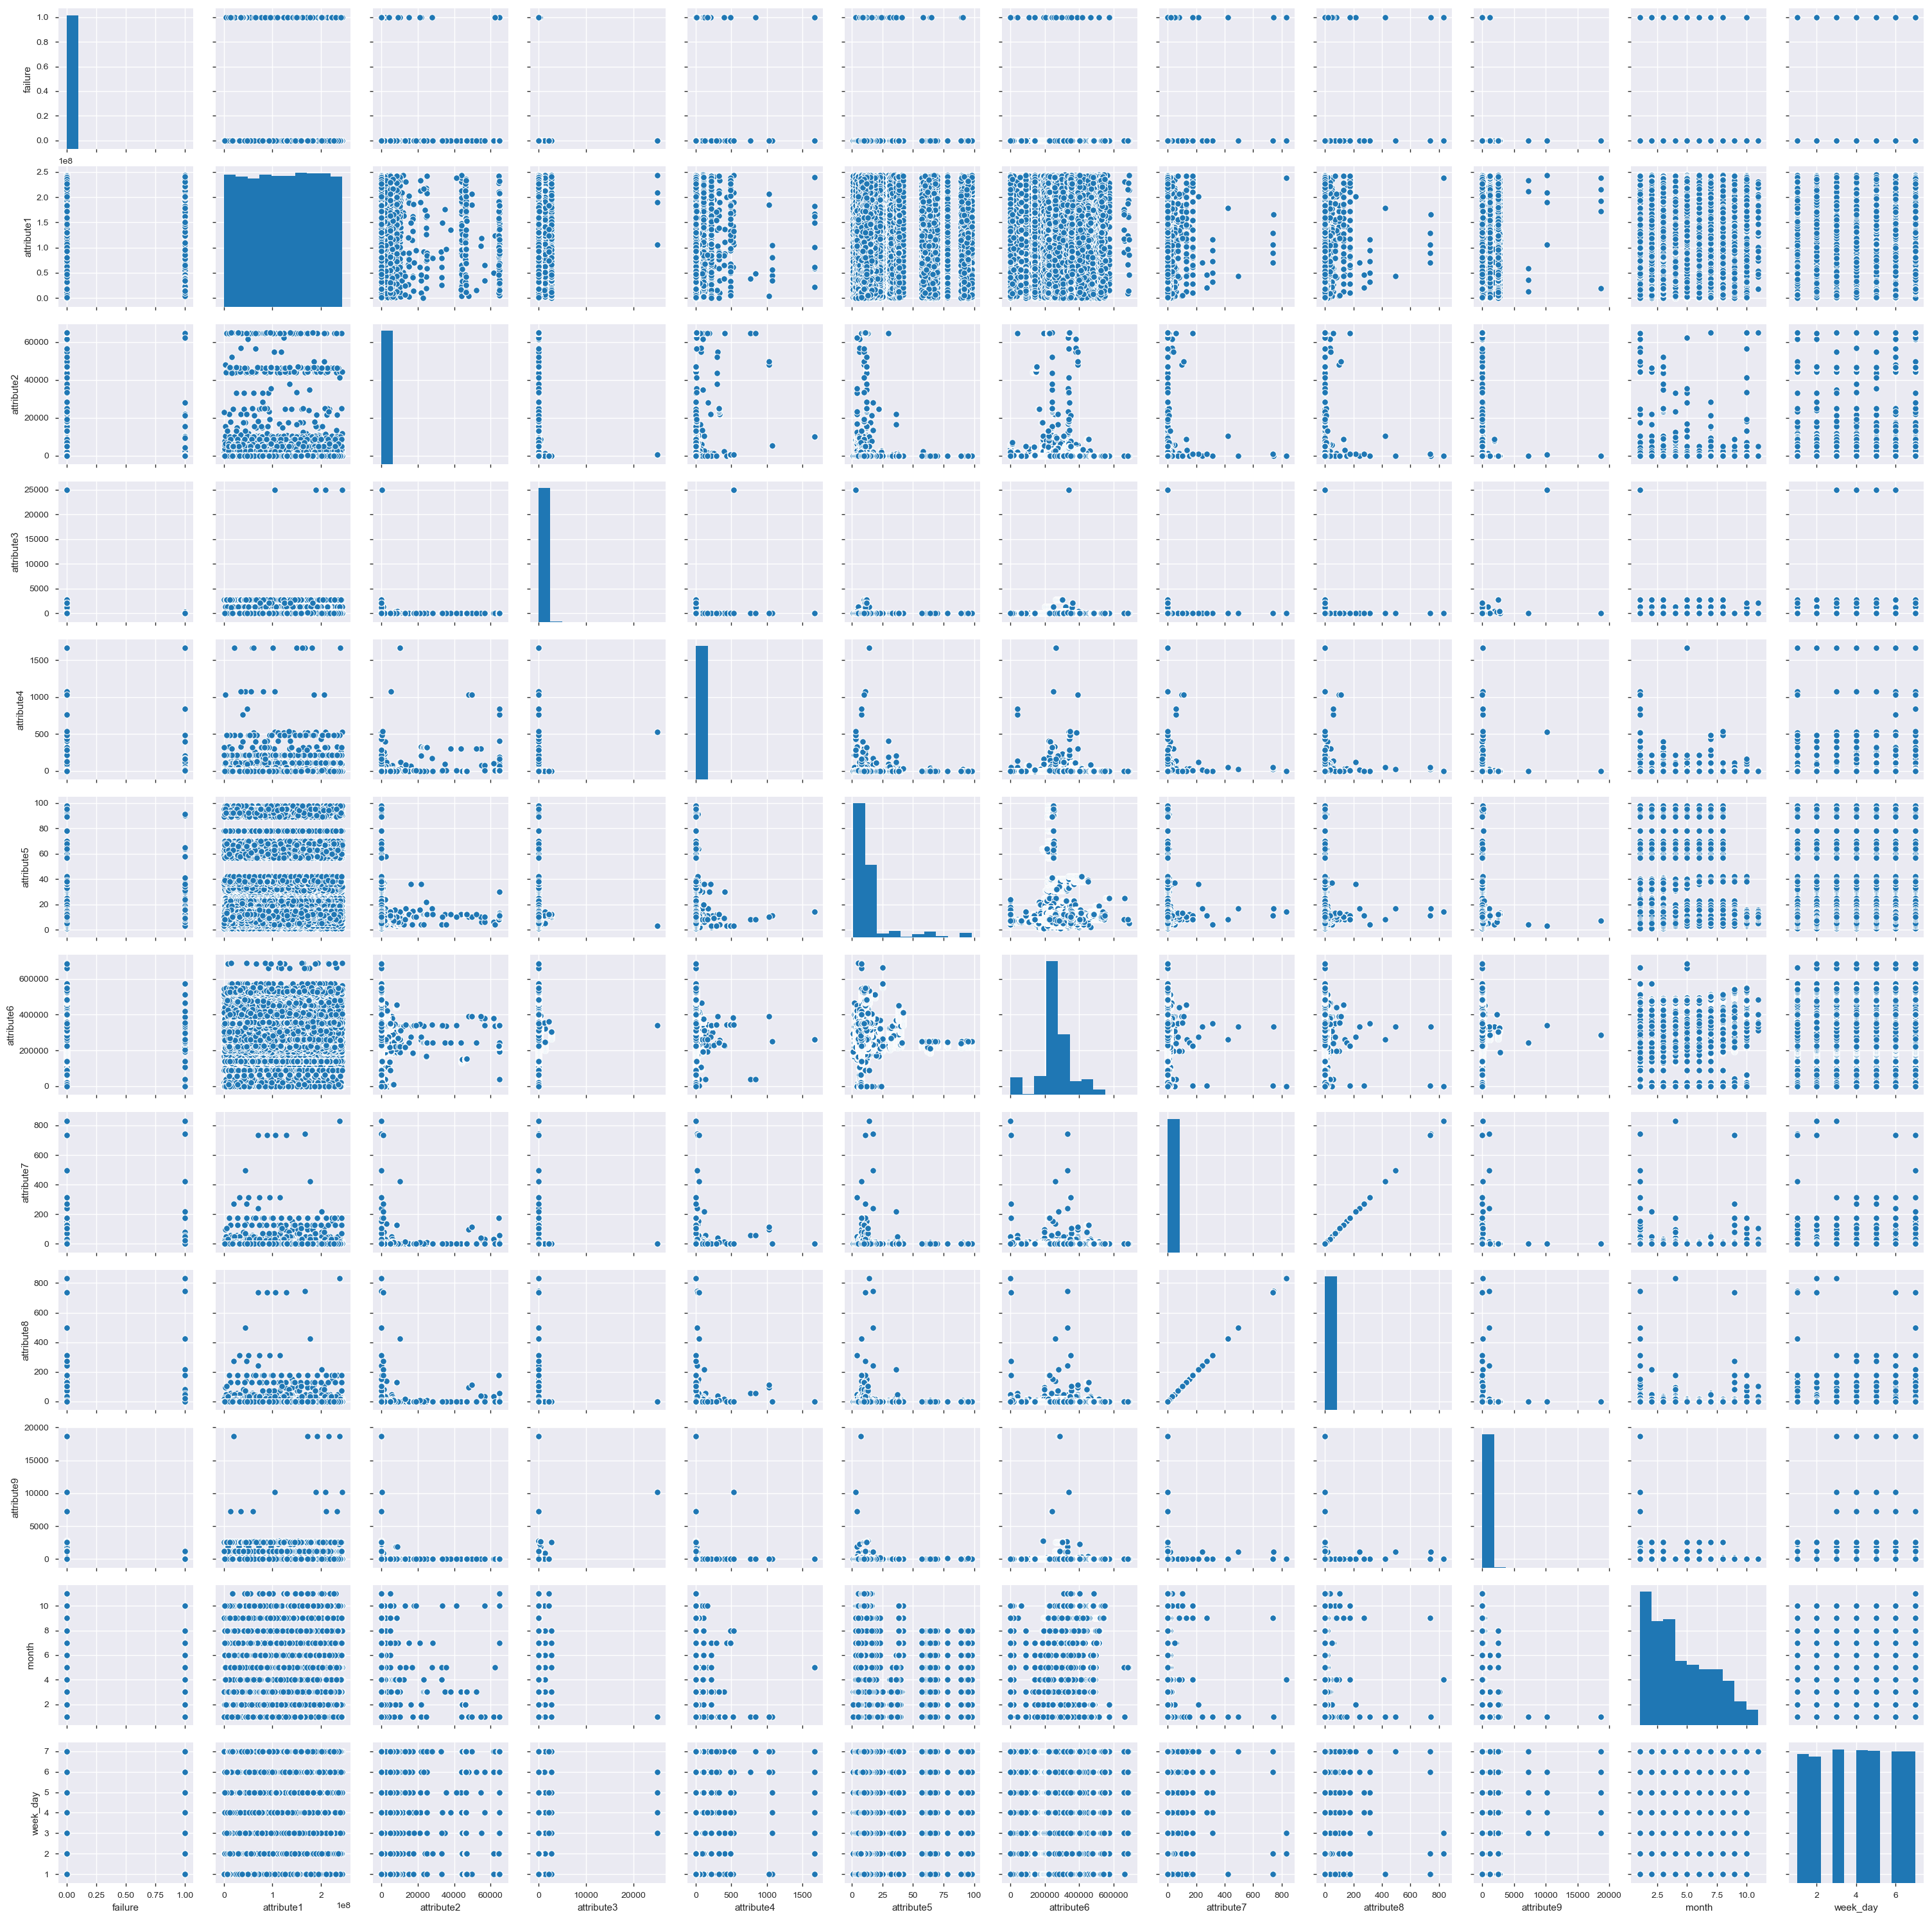

In [42]:
sns.pairplot(df)

It is obvious that attribute7 and attribut8 is highly linear related or equal to each other

In [43]:
(df['attribute7']==df['attribute8']).value_counts()

True    124494
dtype: int64

In [44]:
# then I drop attribute 8, as it is duplicated.
df.drop('attribute8',axis=1,inplace=True)

In [45]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,activedays,month,week_day,max_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0 days,1,3,2015-01-06
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0 days,1,3,2015-01-06
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0 days,1,3,2015-02-17
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0 days,1,3,2015-01-06
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,0 days,1,3,2015-08-24


In [46]:
df2.drop(['date','max_date'],axis=1,inplace=True)

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 15 columns):
device            1168 non-null object
failure           1168 non-null int64
attribute1        1168 non-null float64
attribute2        1168 non-null float64
attribute3        1168 non-null object
attribute4        1168 non-null object
attribute5        1168 non-null object
attribute6        1168 non-null float64
attribute7        1168 non-null object
attribute8        1168 non-null int64
attribute9        1168 non-null object
activedays        1168 non-null int64
month             1168 non-null object
week_day          1168 non-null object
failure_before    1168 non-null int64
dtypes: float64(3), int64(4), object(8)
memory usage: 146.0+ KB


## get dummies on categorical feature

In [48]:
df2.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,activedays,month,week_day,failure_before
0,S1F0,0,0.096188,-0.136376,0,52,6,1.334534,0,0,7,5,1,1,0
1,S1F0,0,-0.090868,-0.145724,0,0,5,4.016345,0,0,0,130,5,7,0
2,S1F0,0,-1.629848,-0.145724,3,0,6,1.290265,0,0,0,5,1,1,0
3,S1F0,0,0.359492,-0.145724,0,0,12,-0.102564,0,0,0,47,2,1,0
4,S1F0,0,0.900875,-0.145724,0,0,6,1.360868,0,0,0,5,1,1,0


In [49]:
df2 = pd.get_dummies(df2,drop_first=True)

In [50]:
df2.shape

(1168, 278)

In [51]:
df2.failure.value_counts()

0    1067
1     101
Name: failure, dtype: int64

# Feature Selection

## Define dependent and independent values

In [52]:
X = df2.drop('failure',axis=1)
Y = df2.failure

## Feature Selection

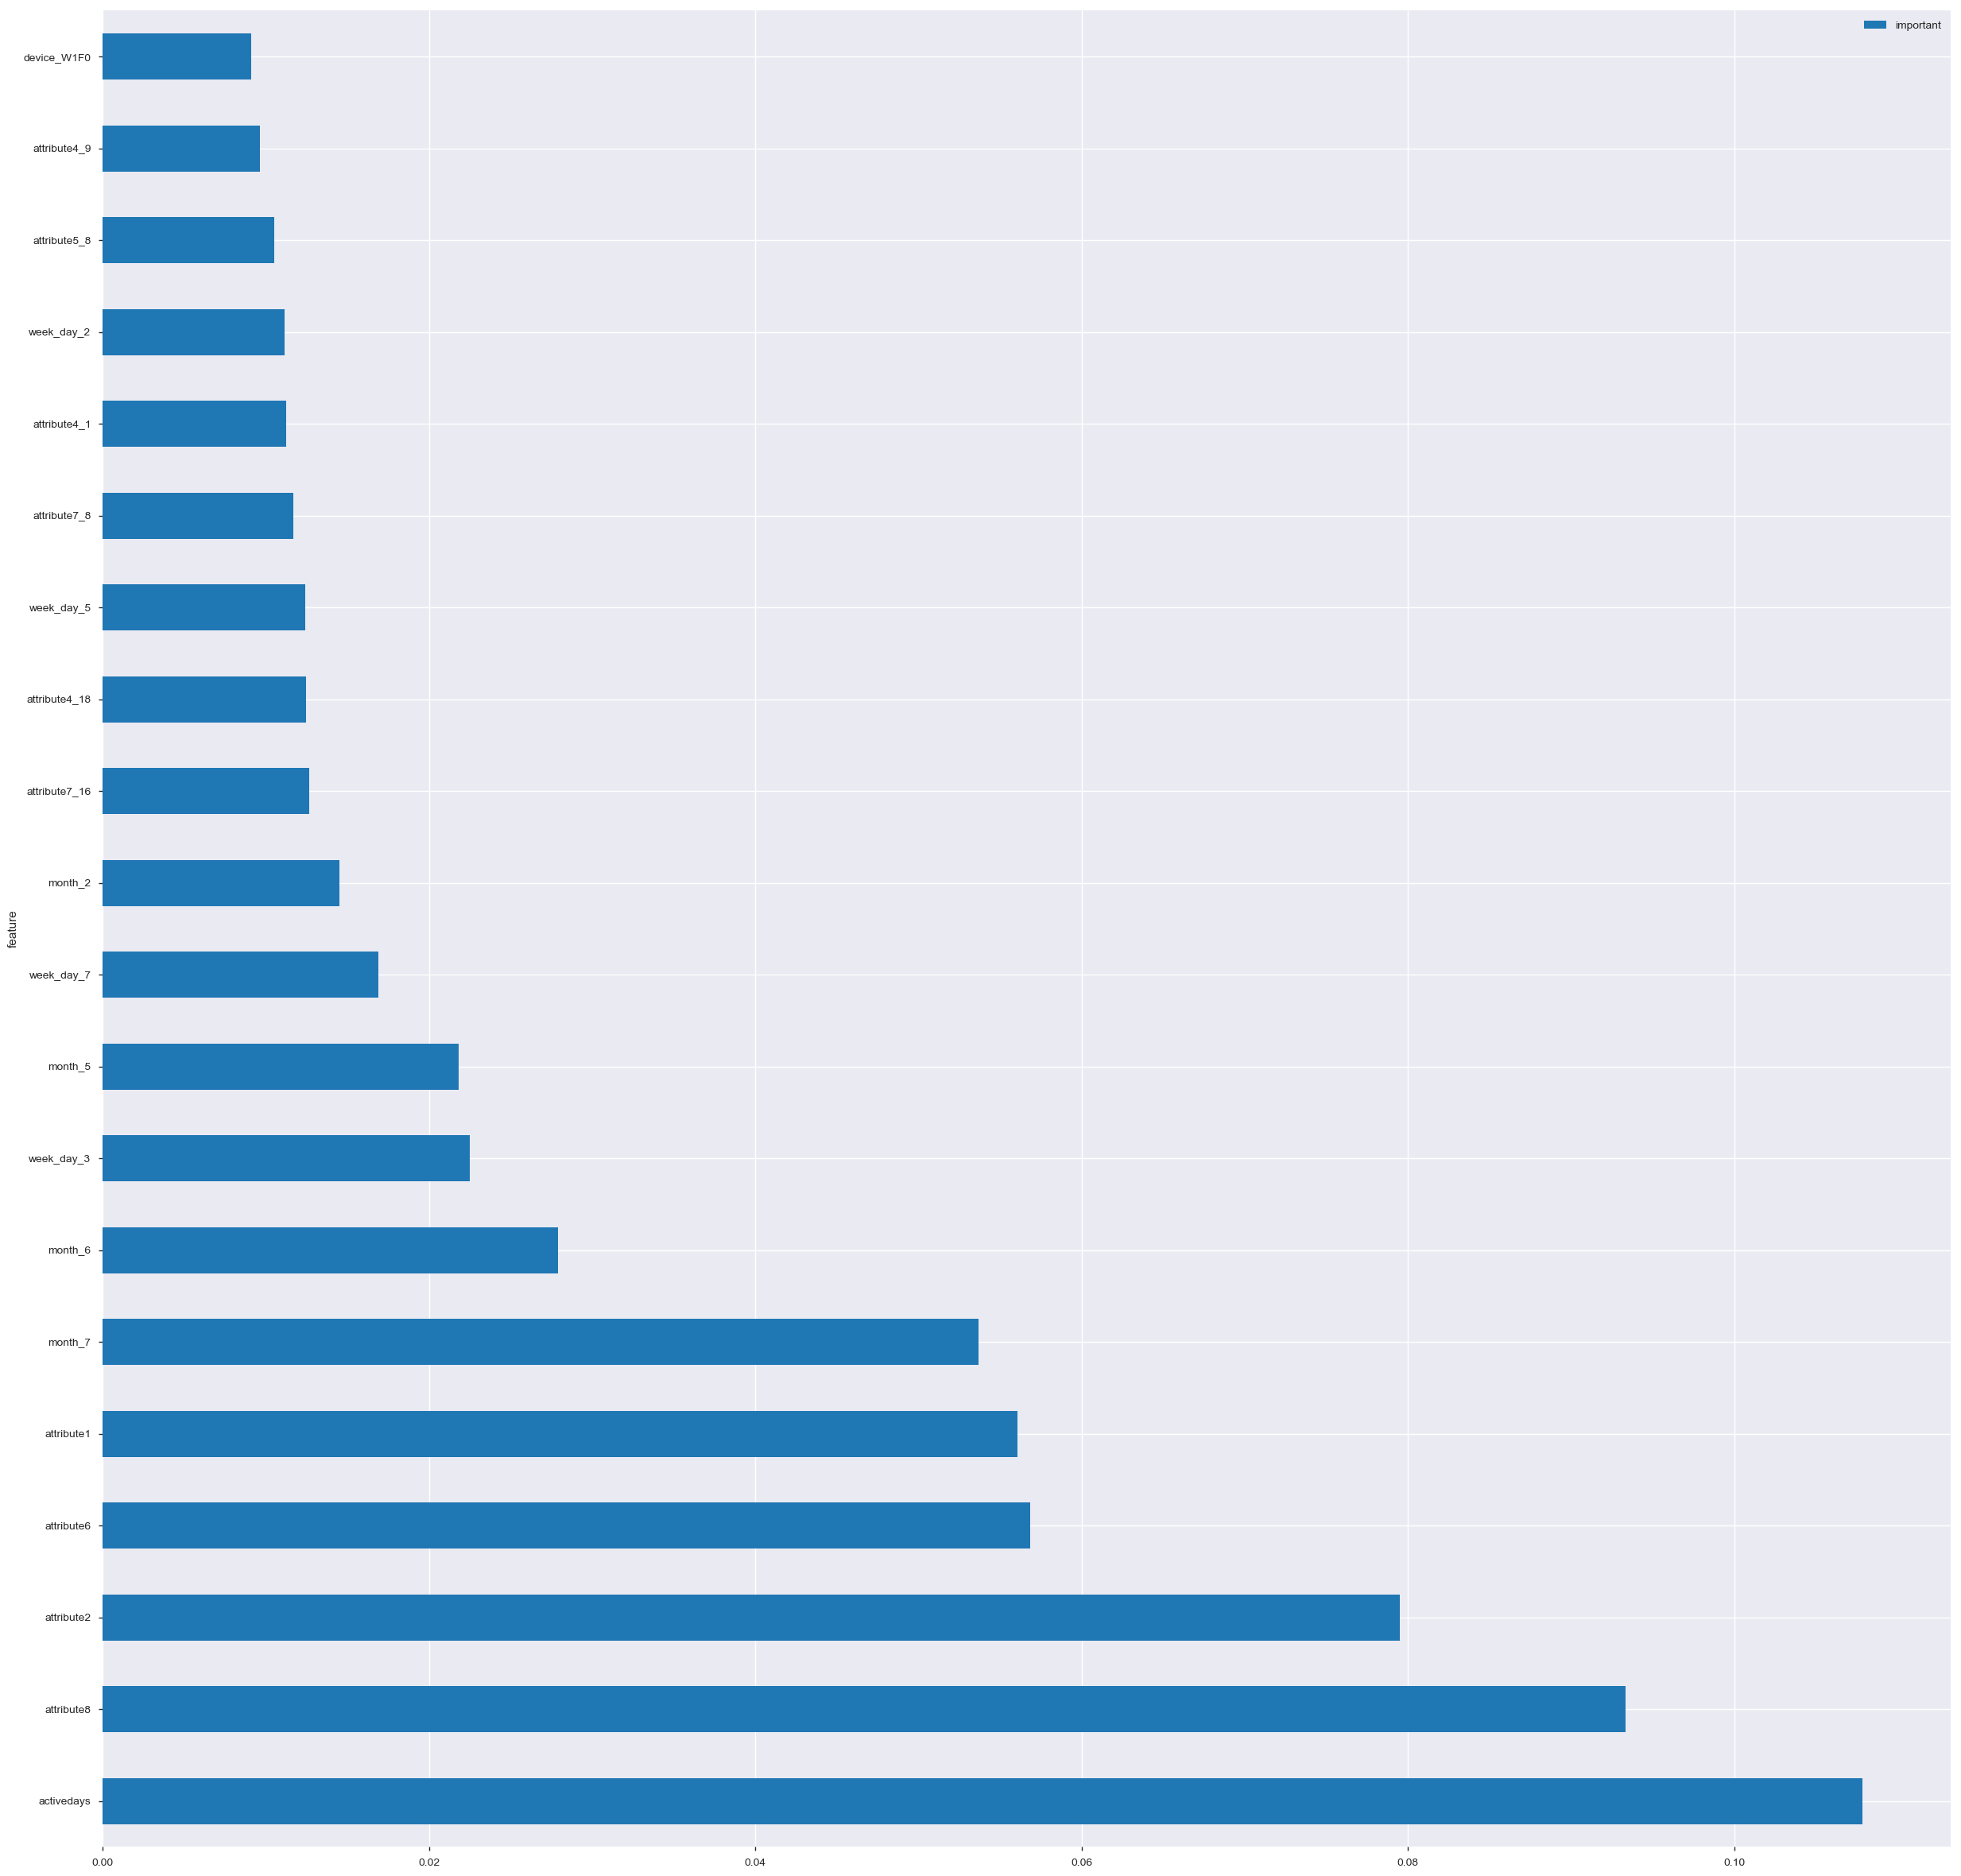

In [53]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature']= X.columns
features['important']=clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:20,:].plot(kind='barh', figsize=(30,30))

In [54]:
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
print (x_reduced.shape)


(1168, 56)


In [55]:
type(x_reduced)

numpy.ndarray

In [56]:
x_reduced=pd.DataFrame(x_reduced)

In [57]:
x_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.096188,-0.136376,1.334534,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.090868,-0.145724,4.016345,0.0,130.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.629848,-0.145724,1.290265,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.359492,-0.145724,-0.102564,0.0,47.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.900875,-0.145724,1.360868,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
x_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 56 columns):
0     1168 non-null float64
1     1168 non-null float64
2     1168 non-null float64
3     1168 non-null float64
4     1168 non-null float64
5     1168 non-null float64
6     1168 non-null float64
7     1168 non-null float64
8     1168 non-null float64
9     1168 non-null float64
10    1168 non-null float64
11    1168 non-null float64
12    1168 non-null float64
13    1168 non-null float64
14    1168 non-null float64
15    1168 non-null float64
16    1168 non-null float64
17    1168 non-null float64
18    1168 non-null float64
19    1168 non-null float64
20    1168 non-null float64
21    1168 non-null float64
22    1168 non-null float64
23    1168 non-null float64
24    1168 non-null float64
25    1168 non-null float64
26    1168 non-null float64
27    1168 non-null float64
28    1168 non-null float64
29    1168 non-null float64
30    1168 non-null float64
31    1168 non-null float

# Resample data-test
when encounter with imbalanced dataset, we always re-sample the data in order to mitigate the effect caused by class imbalance. The two most common techniques are over-sampling and under-sampling. Here I used under-sampling as the dataset is little big.

In [59]:
# import model for imbalanced data set
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [60]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, \
                                                    random_state=42)


rus = RandomOverSampler(random_state=42)
#With my training data craeated, I'll upsample the failed devices using the RandomOverSampler. This method object to over-sample the minority class(es) by picking samples at random with replacement.

X_res, y_res = rus.fit_sample(X_train, y_train)
X_res.shape

X_res = pd.DataFrame(X_res)
#After upsampling, I'll build a random forest model to classify the failed devices.

rf = RandomForestClassifier(n_estimators=5000, random_state=21)

a = rf.fit(X_res,y_res)



rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm

accuracy_score(y_test, rf_test_pred)

print(classification_report_imbalanced(y_test,rf_test_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.56      0.97      0.74      0.58       218
          1       0.69      0.56      0.98      0.62      0.74      0.53        16

avg / total       0.95      0.95      0.59      0.95      0.74      0.57       234



* pre is precision, which is a measure of result relevancy;
* rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
* spe is specificity;
* f1 is the harmonic average of the precision and recall;
* geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
* iba is the index of imbalanced accuracy

# Model Training

## Oversample before cross validate

In [61]:
log=LogisticRegression()
k=KNeighborsClassifier()
gbc =GradientBoostingClassifier()
rgr = RandomForestRegressor(n_estimators=100)
svc = SVC()
rfc = RandomForestClassifier(n_estimators=10)
xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,\
                    hidden_layer_sizes=(5, 2), random_state=1)
algorithms=[k,log,gbc,rgr,svc,rfc,xg_reg,clf]
names=['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost','neunet']

In [62]:
#i=1
#kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
#accuracy = []
#for train_index,test_index in kf.split(x_reduced,Y):     
#    print('\n{} of kfold {}'.format(i,kf.n_splits))     
#    xtr,xvl = x_reduced.loc[train_index],x_reduced.loc[test_index]     
#    ytr,yvl = Y[train_index],Y[test_index]         
#    model = LogisticRegression(random_state=1)     
#    model.fit(xtr, ytr)     
#    pred_test = model.predict(xvl)     
#    score = accuracy_score(yvl,pred_test)
#    accuracy.append(score)
#    print('accuracy_score',score)     
#    i+=1 
#print(np.mean(accuracy))

In [63]:
#from sklearn.model_selection import StratifiedKFold
#
#def cross_validation_fit_predict(x_reduced,Y,algorithms = algorithms, names = names):
#    # fit the data
#    # print metrics
#    Accuracy = []
#    F1 = []
#    Precison =[]
#    Recall =[]
#    for i in range(len(algorithms)):
#        j=1
#        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
#        accuracy = []
#        f1 = [] 
#        precision=[]
#        recall = []
#        for train_index,test_index in kf.split(x_reduced,Y):
#            '\n{} of kfold {}'.format(j,kf.n_splits)
#            xtr,xvl = x_reduced.loc[train_index],x_reduced.loc[test_index]     
#            ytr,yvl = Y[train_index],Y[test_index]         
#            algorithms[i] = algorithms[i].fit(xtr, ytr)  
#            pred_test = algorithms[i].predict(xvl)     
#            score = accuracy_score(yvl,pred_test.round())
#            f1_val = f1_score(yvl,pred_test.round())
#            Prec = precision_score(yvl,pred_test.round())
#            rc = recall_score(yvl,pred_test.round())
#            accuracy.append(score)
#            f1.append(f1_val)
#            precision.append(Prec)
#            recall.append(rc)
#            j+=1
#        mean_score = np.mean(accuracy)
#        mean_f1 = np.mean(f1)
#        mean_pre=np.mean(precision)
#        mean_recall=np.mean(recall)
#        Accuracy.append(mean_score)
#        F1.append(mean_f1)
#        Precision.append(mean_pre)
#        Recall.append(mean_recall)
#    metrics = pd.DataFrame(columns = ['Accuracy', 'F1','Precision','Recall'], index = names)
#    metrics['F1'] = F1
#    metrics['Accuracy'] = Accuracy
#    metrics['Precision']=Precision
#    metrics['Recall']=Recall
#    return metrics.sort_values('Accuracy', ascending = False)

here is the link, why I choose geo and iba
https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/evaluation/plot_metrics.html#sphx-glr-auto-examples-evaluation-plot-metrics-py

In [64]:
iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

In [65]:
def cross_vali_fit_pred_1(X_res, y_res, algorithms = algorithms, names = names):
    # fit the data
    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
    X_res = X_res.as_matrix()
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1 = []
    Recall = []
    Prec = []
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        geo_score = []
        iba_score = []
        accuracy = []
        f1 = []
        recall = []
        prec = []
        for train_index,test_index in kf.split(X_res,y_res):
            xtr,xvd=X_res[train_index],X_res[test_index]
            ytr,yvd=y_res[train_index],y_res[test_index]
            algorithms[i] = algorithms[i].fit(xtr,ytr)
            y_pred_test = algorithms[i].predict(xvd).round()
            accuracy.append(accuracy_score(yvd, y_pred_test))
            geo_score.append(geo(yvd, y_pred_test))
            iba_score.append(iba(yvd, y_pred_test))
            f1.append(f1_score(yvd, y_pred_test,average='macro'))
            recall.append(recall_score(yvd, y_pred_test,average='macro'))
            prec.append(precision_score(yvd, y_pred_test))
            j +=1
        mean_ac = np.mean(accuracy)
        mean_geo = np.mean(geo_score)
        mean_f1 = np.mean(f1)
        mean_iba = np.mean(iba_score)
        mean_recall = np.mean(recall)
        mean_prec = np.mean(prec)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
        Recall.append(mean_recall)
        Prec.append(mean_prec)
        #cm=confusion_matrix(y_test,y_test_pred)
        #print(cm)
    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score','f1','recall','prec'],index=names)
    metrics['Accuracy']=Accuracy
    metrics['geo_score']=Geo_score
    metrics['iba_score']=Iba_score
    metrics['f1']=F1
    metrics['recall']=Recall
    metrics['prec'] =Prec
    return metrics.sort_values('geo_score',ascending=False)

In [66]:
cross_vali_fit_pred_1(X_res, y_res, algorithms = algorithms, names = names)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarnin

,Accuracy,geo_score,iba_score,f1,recall
RandomForestCl,0.988228,0.988146,0.976457,0.988226,0.988228
KNeighborsClassifier,0.987630,0.987546,0.975259,0.987627,0.987630
GradientBoost,0.985872,0.985821,0.971875,0.985870,0.985872
RandomForest,0.982349,0.982147,0.964699,0.982340,0.982349
SVC,0.968789,0.968725,0.938444,0.968784,0.968789
xgboost,0.965259,0.965210,0.931690,0.965256,0.965259
Logistic,0.891653,0.890741,0.793492,0.891470,0.891653
neunet,0.500000,0.000000,0.000000,0.333333,0.500000


In [67]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [68]:
geo(y_test, clf.predict(X_test).round())

0.0

In [69]:
gbc.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [70]:
geo(y_test, gbc.predict(X_test).round())

0.8520078821188573

In [71]:
k.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [72]:
geo(y_test, k.predict(X_test).round())

0.882585079195399

The results are too good to be true

### What happened?

    To see how this works, think about how randomoversampler works. If I upsample a dataset before splitting it into a train and validation set, I could end up with the same observation in both datasets. As a result, a complex enough model will be able to perfectly prdict the value for those observations when prediction on the validation set, inflating the metrix.

## Oversample within cross validation

Now I am gonna oversamle on only the training set. In this way the validation data will not have the same observations as in training set.

In [73]:
def cross_vali_fit_pred_2(X_train, y_train, algorithms = algorithms, names = names):
    # fit the data
    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
    #X_test=X_test.as_matrix()
    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()

    #y_test=y_test.as_matrix()
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1 = []
    Recall = []
    Prec = []
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        geo_score = []
        iba_score = []
        accuracy = []
        f1 = []
        recall = []
        prec = []
        for train_index,test_index in kf.split(X_train, y_train):
            xtr,xvd=X_train[train_index],X_train[test_index]
            ytr,yvd=y_train[train_index],y_train[test_index]
            xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
            algorithms[i] = algorithms[i].fit(xtr_res,ytr_res)
            y_pred_test = algorithms[i].predict(xvd).round()
            accuracy.append(accuracy_score(yvd, y_pred_test))
            geo_score.append(geo(yvd, y_pred_test))
            iba_score.append(iba(yvd, y_pred_test))
            f1.append(f1_score(yvd, y_pred_test,average='macro'))
            recall.append(recall_score(yvd, y_pred_test,average='macro'))
            prec.append(precision_score(yvd, y_pred_test))
            j +=1
        mean_ac = np.mean(accuracy)
        mean_geo = np.mean(geo_score)
        mean_f1 = np.mean(f1)
        mean_iba = np.mean(iba_score)
        mean_recall = np.mean(recall)
        mean_prec = np.mean(prec)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
        Recall.append(mean_recall)
        Prec.append(mean_prec)
        #cm=confusion_matrix(y_test,y_test_pred)
        #print(cm)
    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score','f1','recall','prec'],index=names)
    metrics['Accuracy']=Accuracy
    metrics['geo_score']=Geo_score
    metrics['iba_score']=Iba_score
    metrics['f1']=F1
    metrics['recall']=Recall
    metrics['prec']=Prec
    return metrics.sort_values('geo_score',ascending=False)

In [74]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [75]:
#X_train = X_train.as_matrix()

In [76]:
#y_train = y_train.as_matrix()

In [77]:
cross_vali_fit_pred_2(X_train, y_train, algorithms = algorithms, names = names)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433

,Accuracy,geo_score,iba_score,f1,recall
GradientBoost,0.965752,0.909404,0.828022,0.900386,0.912349
SVC,0.962521,0.896023,0.803993,0.889542,0.899986
KNeighborsClassifier,0.962515,0.895515,0.803918,0.888966,0.899983
xgboost,0.940055,0.860549,0.742880,0.835148,0.866453
Logistic,0.914370,0.817888,0.670769,0.780372,0.825861
RandomForest,0.945409,0.813772,0.662967,0.833578,0.827052
RandomForestCl,0.947530,0.733050,0.545395,0.810087,0.769997
neunet,0.091007,0.000000,0.000000,0.083415,0.500000


## Model evaluation

In [78]:
X_test=X_test.as_matrix()

y_test=y_test.as_matrix()
probs1 = k.predict_proba(X_test)
probs2 = xg_reg.predict_proba(X_test)
probs3 = gbc.predict_proba(X_test)
probs4 = rfc.predict_proba(X_test)
probs1 = probs1[:,1]
probs2 = probs2[:,1]
probs3 = probs3[:,1]
probs4 = probs4[:,1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


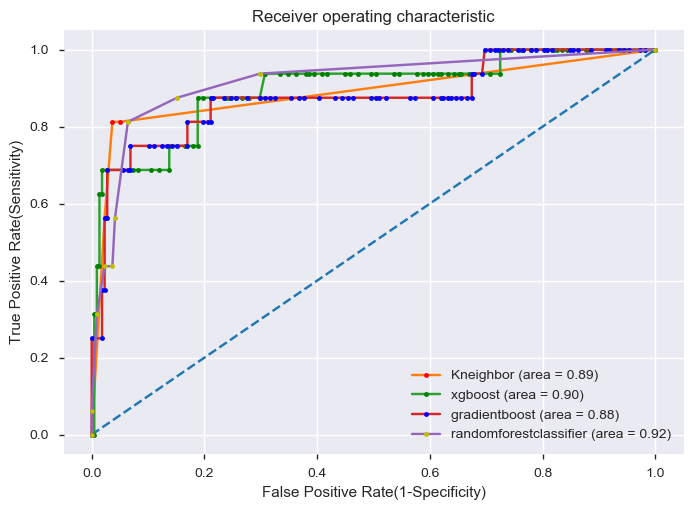

In [79]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr1, tpr1, marker='.', markerfacecolor='r',label='Kneighbor (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, marker='.', markerfacecolor='g',label='xgboost (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, marker='.', markerfacecolor='b',label='gradientboost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, marker='.',markerfacecolor='y',label='randomforestclassifier (area = %0.2f)' % roc_auc4)
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [80]:
geo(y_test, k.predict(X_test).round())

0.882585079195399

In [98]:
geo(y_test, gbc.predict(X_test).round())

0.7796141129671875

In [99]:
geo(y_test, svc.predict(X_test).round())

0.882585079195399

In [100]:
geo(y_test, clf.predict(X_test).round())#neutral network result is 0?

0.0

In [101]:
geo(y_test, xg_reg.predict(X_test).round())

0.8176661798383105

In [102]:
geo(y_test, rfc.predict(X_test).round())

0.6538085318579708

## Model tunning

In [84]:
X_train = X_train.as_matrix()
y_train = y_train.as_matrix()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [104]:
Geo1=[]
Geo2=[]
estimators = [i for i in range(5,150,10)]
Learning_rate = [i for i in np.arange(0.05,0.4,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in estimators:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
        geo_score.append(precision_score(yvd, y_pred_test))
    Geo1.append(np.mean(geo_score))

print(Geo1)

[0.6208929563728325, 0.6356515849704704, 0.6644094345435935, 0.6781230932237124, 0.6886240157045109, 0.6994115601365343, 0.7103750943799595, 0.7185977450625284, 0.7280681887708033, 0.7363371844300636, 0.7421615009231106, 0.7469357329212851, 0.7508623455170252, 0.754576259612748, 0.7582711756385647]


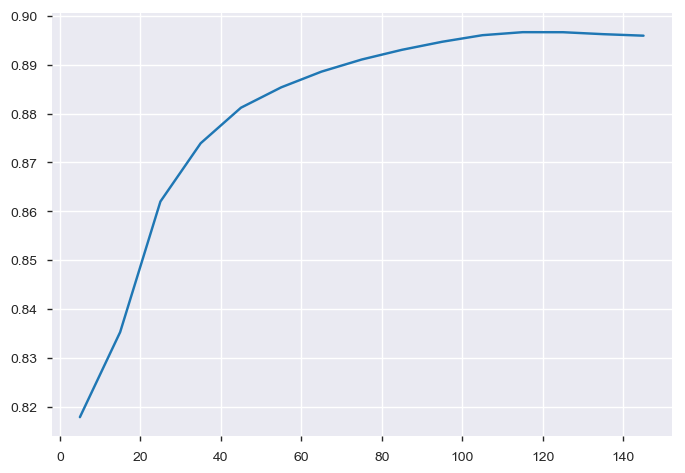

In [86]:
plt.plot(estimators,Geo1)

In [87]:
Geo2=[]
Learning_rate = [i for i in np.arange(0.01,0.2,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in Learning_rate:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=100,learning_rate=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
        geo_score.append(geo(yvd, y_pred_test))
    Geo2.append(np.mean(geo_score))

print(Geo2)

[0.8230661931891534, 0.8735850037083172, 0.8852216305943569, 0.8912671466948057, 0.8915300934481739, 0.890880703433196, 0.8892086993549655]


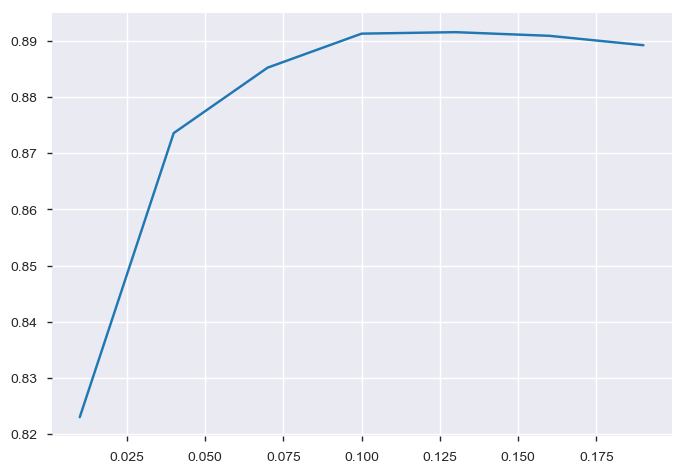

In [88]:
plt.plot(Learning_rate,Geo2)

# Deployment

In [89]:
gbc =GradientBoostingClassifier(n_estimators=100,learning_rate=0.1)

In [105]:
Geo=[]
prec=[]
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for n_index,test_index in kf.split(X_train, y_train):
    xtr,xvd=X_train[train_index],X_train[test_index]
    ytr,yvd=y_train[train_index],y_train[test_index]
    xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
    gbc =gbc.fit(xtr_res,ytr_res)
    y_pred_test = gbc.predict(xvd).round()
    
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    Geo.append(geo(yvd, y_pred_test))
    prec.append(precision_score(yvd, y_pred_test))

print(np.mean(Geo))

0.9803701694977821


In [107]:
np.mean(prec)

0.9755555555555556

In [91]:
prob=gbc.predict_proba(X_test)

In [92]:
prob

array([[0.98846379, 0.01153621],
       [0.96246312, 0.03753688],
       [0.11887719, 0.88112281],
       [0.1577935 , 0.8422065 ],
       [0.98313087, 0.01686913],
       [0.98817081, 0.01182919],
       [0.94066447, 0.05933553],
       [0.90343984, 0.09656016],
       [0.98391985, 0.01608015],
       [0.88681649, 0.11318351],
       [0.98712539, 0.01287461],
       [0.7191481 , 0.2808519 ],
       [0.9679434 , 0.0320566 ],
       [0.97748076, 0.02251924],
       [0.93972273, 0.06027727],
       [0.98999455, 0.01000545],
       [0.85974794, 0.14025206],
       [0.95574619, 0.04425381],
       [0.95421716, 0.04578284],
       [0.35390026, 0.64609974],
       [0.96369165, 0.03630835],
       [0.98667943, 0.01332057],
       [0.98173606, 0.01826394],
       [0.98779086, 0.01220914],
       [0.98757247, 0.01242753],
       [0.95552247, 0.04447753],
       [0.96721156, 0.03278844],
       [0.61684052, 0.38315948],
       [0.98422444, 0.01577556],
       [0.98758608, 0.01241392],
       [0.

In [93]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [94]:
y_pred_prob = pd.DataFrame(y_test)
y_pred_prob['0']=prob[:,0]

y_pred_prob['1']=prob[:,1]

y_pred_prob.head(20)

,0,0,1
0,0,0.988464,0.011536
1,0,0.962463,0.037537
2,0,0.118877,0.881123
3,0,0.157794,0.842206
4,0,0.983131,0.016869
5,0,0.988171,0.011829
6,0,0.940664,0.059336
7,0,0.903440,0.096560
8,0,0.983920,0.016080
9,0,0.886816,0.113184
